In [1]:
import os
os.chdir('..')

In [2]:
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
def get_calendar_age_and_id(segment, age_data):
    test_id = segment.split('_')[0]
    target_numpy = age_data.loc[test_id].corrected_age
    return float(target_numpy), test_id

def create_dataframe(y_pred, segments, age_file):
    age_data = pd.read_csv(age_file, dtype={'test_id': str}).set_index('test_id')

    y_true, ids_val = zip(*[get_calendar_age_and_id(segment, age_data) for segment in segments])
    
    df_val = pd.DataFrame({
        'y_true': np.array(y_true),
        'y_pred': np.array(y_pred),
        'test_id': ids_val
    })

    return df_val

In [4]:
df_val_all = pd.DataFrame()

age_file = Path('metadata', 'combined.csv')
fts_data = pd.read_csv('data/features.csv')

models = [
    'lr', 'rf', 'gb', 'xgb',
    'stgcn-physical', 'stgcn-xy', 'stgcn', 'aagcn', 'ms-aagcn', 'ms-aagcn-fts',
]

folds = [f'fold_{i}' for i in range(1, 11)]

for model_name in tqdm(models):
    model_dir = Path('results', model_name)

    for fold in folds:
        result_dir = Path(model_dir, fold)

        y_pred_val = np.load(Path(result_dir, 'val_predictions.npy'))

        with open(Path(result_dir, 'metadata.json'), 'r') as f:
            metadata = json.load(f)

        val_segments = metadata['val_segments']

        df_val = create_dataframe(y_pred_val, val_segments, age_file)

        df_val['fold'] = fold
        df_val['model'] = model_name

        df_val_all = pd.concat([df_val_all, df_val])

df_train_all = df_val_all.merge(fts_data[['test_id', 'outcome']], on='test_id', how='left')
df_val_all = df_val_all.merge(fts_data[['test_id', 'outcome']], on='test_id', how='left')

df_val_all.sample(frac=1).head()

  0%|          | 0/10 [00:00<?, ?it/s]

,y_true,y_pred,test_id,fold,model,outcome
132820,113.0,101.001640,v92,fold_9,ms-aagcn-fts,0
111557,113.0,96.744698,v92,fold_9,ms-aagcn,0
104337,69.0,81.930115,0134,fold_6,ms-aagcn,0
124819,33.0,76.597473,0001,fold_5,ms-aagcn-fts,0
94480,103.0,76.289970,0011,fold_1,ms-aagcn,0


In [5]:
ages = pd.read_csv(age_file)
ages.describe()

,corrected_age,outcome
count,180.000000,180.000000
mean,90.716667,0.422222
std,22.147115,0.668155
min,27.000000,0.000000
25%,85.000000,0.000000
50%,92.000000,0.000000
75%,101.000000,1.000000
max,158.000000,2.000000


In [6]:
df_severe  = pd.DataFrame()

for model in models:
    file_path = f'predictions/{model}_predictions.csv'
    model_df = pd.read_csv(file_path)
    model_df['model'] = model
    df_severe  = pd.concat([df_severe, model_df], ignore_index=True)

df_severe.sample(frac=1).head()

,fold,segment,test_id,outcome,y_true,y_pred,model
1475,6,0116_1_0,0116,2.0,143,76.948760,stgcn-physical
11237,5,v31_1_5,v31,2.0,116,99.664630,ms-aagcn-fts
11491,7,0091_3_1,0091,2.0,52,78.009155,ms-aagcn-fts
10019,9,0014_1_0,0014,2.0,98,94.001230,ms-aagcn
2089,9,0093_1_5,0093,2.0,61,81.815550,stgcn-physical


### Group by subject and calculate metrics

In [7]:
results_df_val = pd.DataFrame(columns=['Model', 'RMSE (days)', 'MAE (days)', 'MAPE (%)', 'R2'])

for model in tqdm(models):
    model_df = df_val_all[df_val_all['model'] == model]
    grouped_df = model_df.groupby('test_id').agg({'y_true': ['mean'], 'y_pred': ['mean']})

    rmse = mean_squared_error(grouped_df['y_true']['mean'], grouped_df['y_pred']['mean'], squared=False)
    mae = mean_absolute_error(grouped_df['y_true']['mean'], grouped_df['y_pred']['mean'])
    mape = 100*mean_absolute_percentage_error(grouped_df['y_true']['mean'], grouped_df['y_pred']['mean'])
    r2 = r2_score(grouped_df['y_true']['mean'], grouped_df['y_pred']['mean'])

    results_df_val = results_df_val.append({
        'Model': model, 
        'RMSE (days)': f'{rmse:.2f}', 
        'MAE (days)': f'{mae:.2f}', 
        'MAPE (%)': f'{mape:.2f}', 
        'R2': f'{r2:.2f}'}, ignore_index=True)

print(results_df_val)

  0%|          | 0/10 [00:00<?, ?it/s]

            Model RMSE (days) MAE (days) MAPE (%)    R2
0              lr       19.65      14.94    20.10  0.12
1              rf       19.13      13.97    19.96  0.16
2              gb       18.42      14.06    19.41  0.23
3             xgb       18.35      14.28    19.43  0.23
4  stgcn-physical       16.97      12.12    18.24  0.34
5        stgcn-xy       17.79      12.69    19.16  0.28
6           stgcn       16.86      12.37    18.28  0.35
7           aagcn       16.51      11.65    17.39  0.38
8        ms-aagcn       16.66      11.78    17.72  0.37
9    ms-aagcn-fts       17.21      12.88    18.09  0.32


### Group by fold and subject and calculate metrics

In [8]:
results_df_val = pd.DataFrame(columns=['Model', 'RMSE (days)', 'MAE (days)', 'MAPE (%)', 'R2'])

for model in tqdm(models):
    model_df = df_val_all[df_val_all['model'] == model]
    model_df = model_df[(model_df['y_true'] >= 70) & (model_df['y_true'] <= 140)]

    # List to store metrics for each fold
    rmse_list, mae_list, mape_list, r2_list = [], [], [], []

    # Iterate through each fold
    for fold in model_df['fold'].unique():
        fold_df = model_df[model_df['fold'] == fold]
        grouped_fold_df = fold_df.groupby('test_id').agg({'y_true': 'mean', 'y_pred': 'mean'}).reset_index()

        rmse = mean_squared_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'], squared=False)
        mae = mean_absolute_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
        mape = 100 * mean_absolute_percentage_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
        r2 = r2_score(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])

        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)

    # Calculate mean and standard deviation for each metric
    rmse_mean, rmse_std = np.mean(rmse_list), np.std(rmse_list)
    mae_mean, mae_std = np.mean(mae_list), np.std(mae_list)
    mape_mean, mape_std = np.mean(mape_list), np.std(mape_list)
    r2_mean, r2_std = np.mean(r2_list), np.std(r2_list)

    # Append results to DataFrame
    results_df_val = results_df_val.append({
        'Model': model, 
        'RMSE (days)': f'{rmse_mean:.2f} ± {rmse_std:.2f}', 
        'MAE (days)': f'{mae_mean:.2f} ± {mae_std:.2f}', 
        'MAPE (%)': f'{mape_mean:.2f} ± {mape_std:.2f}', 
        'R2': f'{r2_mean:.2f} ± {r2_std:.2f}'}, ignore_index=True)

print(results_df_val)

  0%|          | 0/10 [00:00<?, ?it/s]

            Model   RMSE (days)    MAE (days)      MAPE (%)            R2
0              lr  15.95 ± 2.70  12.60 ± 2.03  12.72 ± 1.77  -0.97 ± 0.43
1              rf  14.42 ± 2.25  10.87 ± 1.79  10.85 ± 1.86  -0.66 ± 0.57
2              gb  15.32 ± 2.26  12.02 ± 2.14  12.31 ± 2.57  -1.00 ± 1.05
3             xgb  15.57 ± 2.68  12.44 ± 1.81  12.78 ± 2.19  -1.10 ± 1.26
4  stgcn-physical  11.48 ± 1.97   9.06 ± 1.49   9.08 ± 1.48  -0.03 ± 0.27
5        stgcn-xy  11.96 ± 2.78   9.50 ± 2.56   9.49 ± 2.26  -0.11 ± 0.37
6           stgcn  11.60 ± 2.33   9.44 ± 2.23   9.45 ± 2.19  -0.04 ± 0.29
7           aagcn  11.12 ± 2.92   8.56 ± 2.53   8.40 ± 2.34   0.05 ± 0.30
8        ms-aagcn  11.36 ± 1.99   8.83 ± 1.70   8.75 ± 1.53  -0.01 ± 0.29
9    ms-aagcn-fts  13.61 ± 1.66  10.52 ± 1.79  10.72 ± 2.00  -0.46 ± 0.36


In [12]:
results_df_val = pd.DataFrame(columns=['Model', 'RMSE (days)', 'MAE (days)', 'MAPE (%)', 'R2'])

for model in tqdm(models):
    model_df = df_val_all[df_val_all['model'] == model]

    # List to store metrics for each fold
    rmse_list, mae_list, mape_list, r2_list = [], [], [], []

    # Iterate through each fold
    for fold in model_df['fold'].unique():
        fold_df = model_df[model_df['fold'] == fold]
        grouped_fold_df = fold_df.groupby('test_id').agg({'y_true': 'mean', 'y_pred': 'mean'}).reset_index()

        rmse = mean_squared_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'], squared=False)
        mae = mean_absolute_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
        mape = 100 * mean_absolute_percentage_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
        r2 = r2_score(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])

        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)

    # Calculate mean and standard deviation for each metric
    rmse_mean, rmse_std = np.mean(rmse_list), np.std(rmse_list)
    mae_mean, mae_std = np.mean(mae_list), np.std(mae_list)
    mape_mean, mape_std = np.mean(mape_list), np.std(mape_list)
    r2_mean, r2_std = np.mean(r2_list), np.std(r2_list)

    # Append results to DataFrame
    results_df_val = results_df_val.append({
        'Model': model, 
        'RMSE (days)': f'{rmse_mean:.2f} ± {rmse_std:.2f}', 
        'MAE (days)': f'{mae_mean:.2f} ± {mae_std:.2f}', 
        'MAPE (%)': f'{mape_mean:.2f} ± {mape_std:.2f}', 
        'R2': f'{r2_mean:.2f} ± {r2_std:.2f}'}, ignore_index=True)

print(results_df_val)

  0%|          | 0/10 [00:00<?, ?it/s]

            Model   RMSE (days)    MAE (days)      MAPE (%)           R2
0              lr  19.50 ± 2.49  14.94 ± 1.61  20.20 ± 5.74  0.03 ± 0.23
1              rf  18.86 ± 3.39  13.98 ± 2.57  20.05 ± 7.17  0.10 ± 0.23
2              gb  18.12 ± 3.56  14.07 ± 2.85  19.50 ± 7.36  0.15 ± 0.26
3             xgb  18.02 ± 3.73  14.30 ± 2.57  19.52 ± 6.83  0.16 ± 0.27
4  stgcn-physical  16.76 ± 2.77  12.12 ± 1.88  18.30 ± 5.73  0.28 ± 0.20
5        stgcn-xy  17.57 ± 2.70  12.64 ± 2.74  19.18 ± 5.62  0.21 ± 0.18
6           stgcn  16.63 ± 2.77  12.34 ± 2.68  18.30 ± 5.76  0.29 ± 0.18
7           aagcn  16.30 ± 2.60  11.61 ± 2.05  17.42 ± 5.09  0.32 ± 0.13
8        ms-aagcn  16.41 ± 3.02  11.77 ± 1.99  17.78 ± 5.94  0.30 ± 0.21
9    ms-aagcn-fts  16.96 ± 2.93  12.87 ± 2.31  18.14 ± 5.65  0.27 ± 0.15


### Predicted vs Ground Truth Plot

- Pearson's Correlation Coefficient (r): This measures the linear correlation between the predicted and actual values. A value closer to 1 indicates a strong positive correlation.
- P-value for Pearson's Correlation: This tests the hypothesis of no correlation between predicted and actual values. A low p-value (typically <0.05) indicates that the correlation is statistically significant.

### Bland-Altman Plot

- Mean Bias: The average difference between the predicted and actual values. It gives an idea of whether the predictions are consistently higher or lower than the actual values.
- Limits of Agreement: Typically calculated as the mean bias ± 1.96 times the standard deviation of the differences. This interval estimates where 95% of the differences between predicted and actual values lie.

lr


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


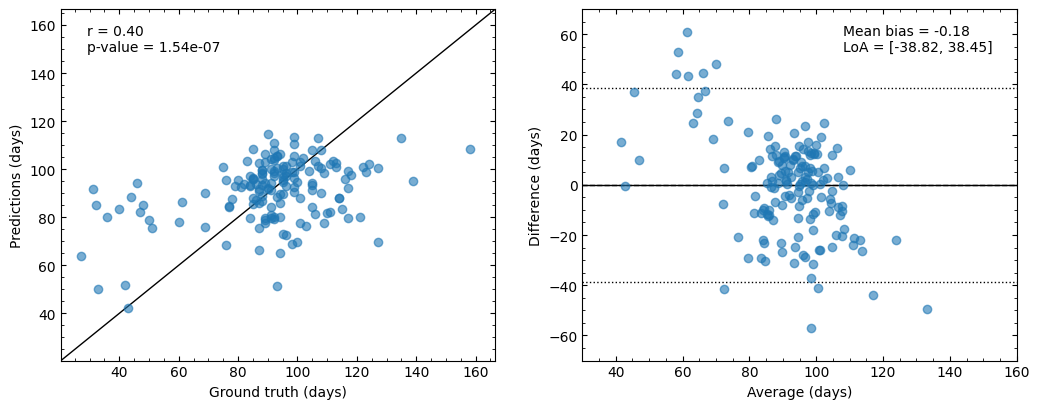

rf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


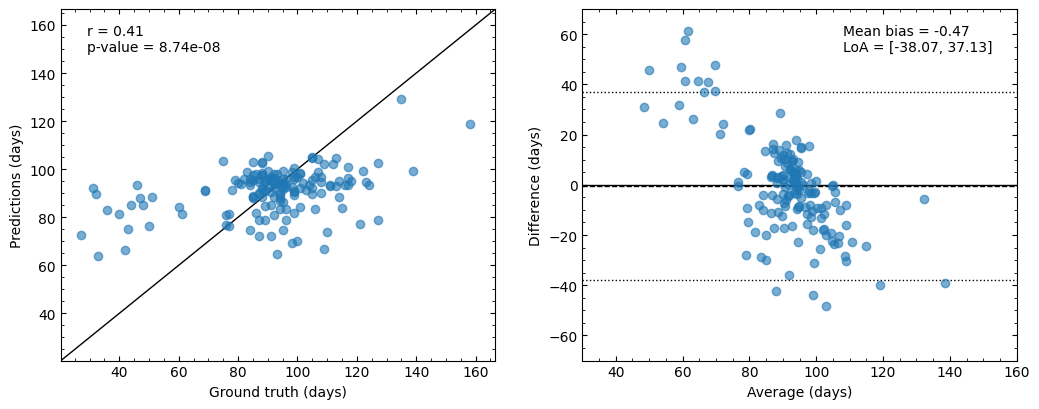

gb


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


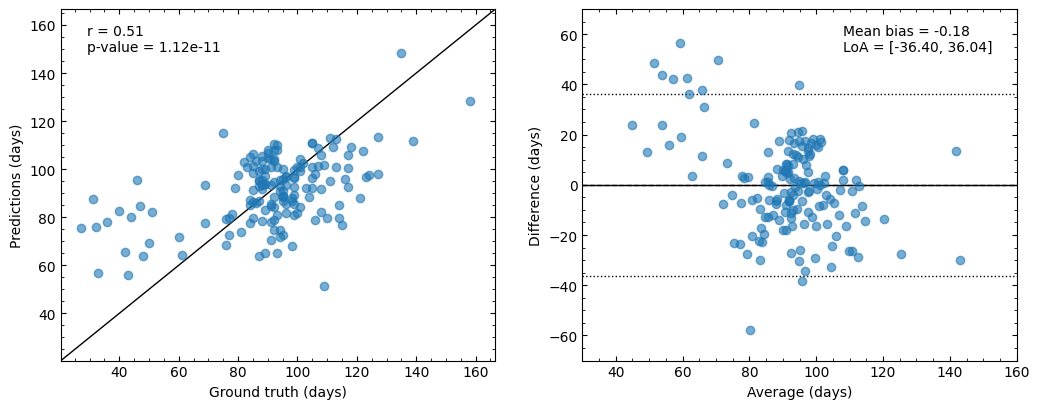

xgb


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


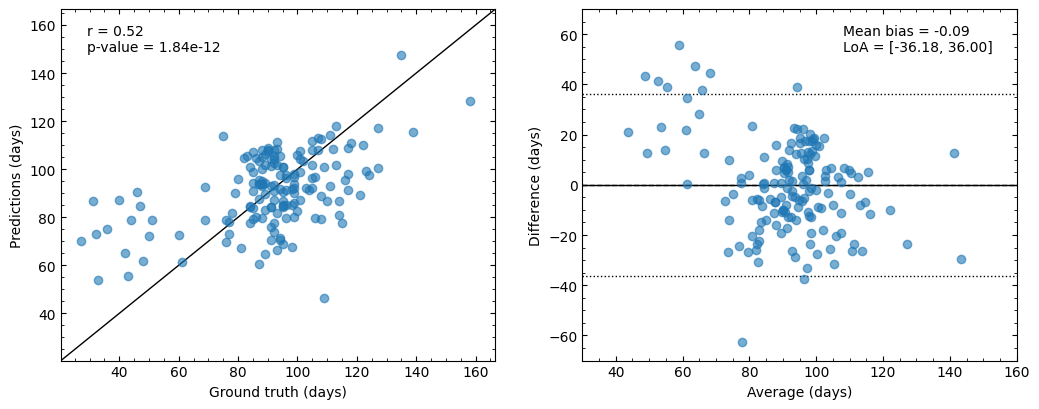

stgcn-physical


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


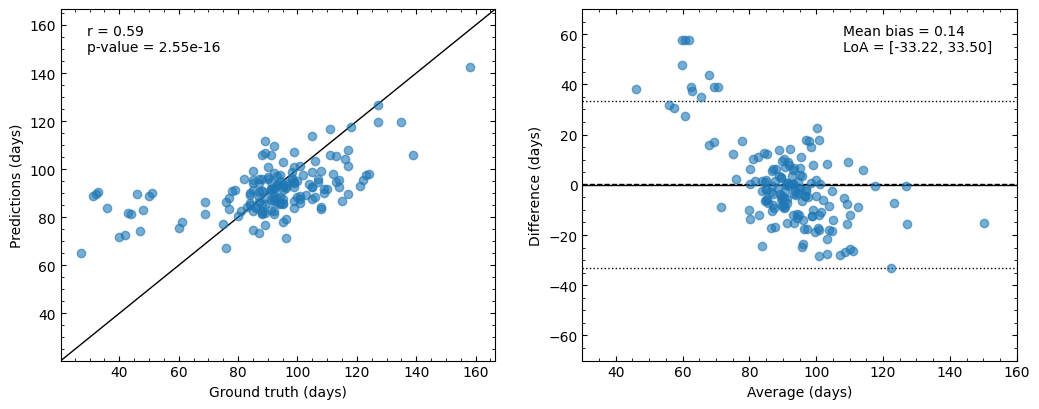

stgcn-xy


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


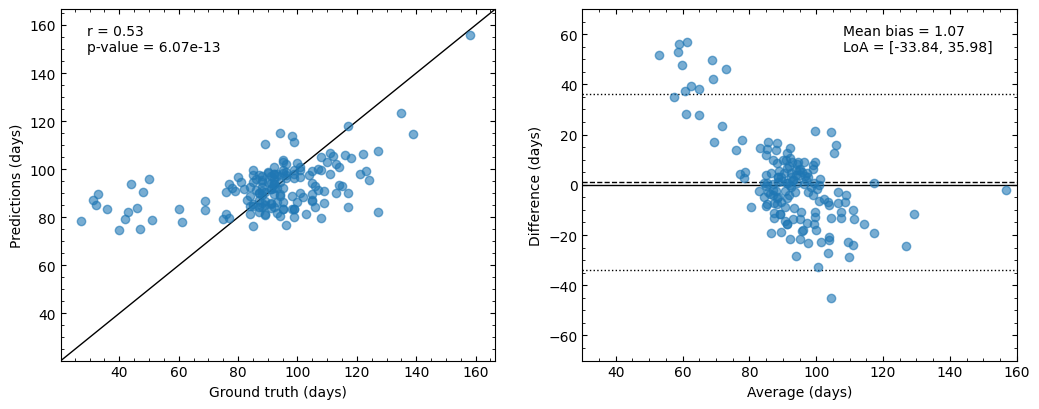

stgcn


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


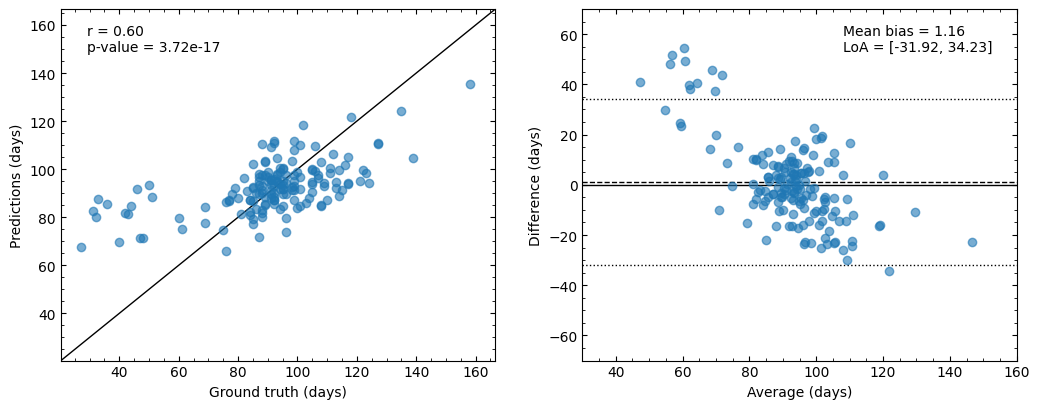

aagcn


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


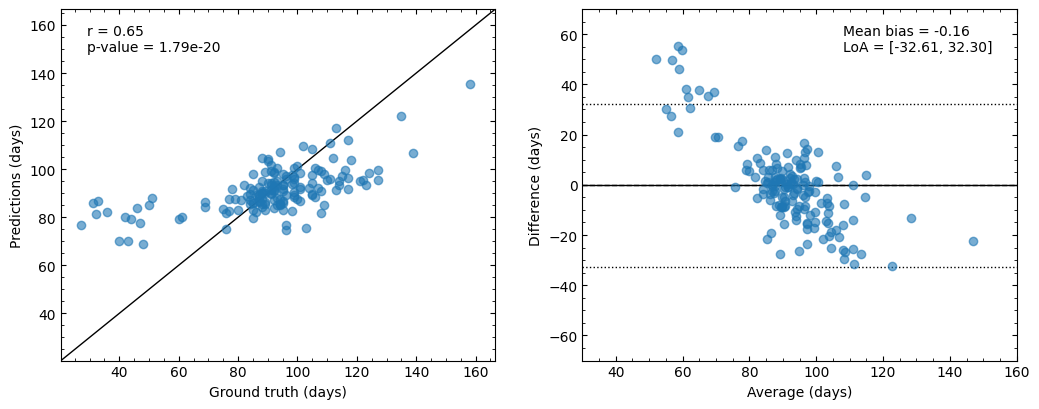

ms-aagcn


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


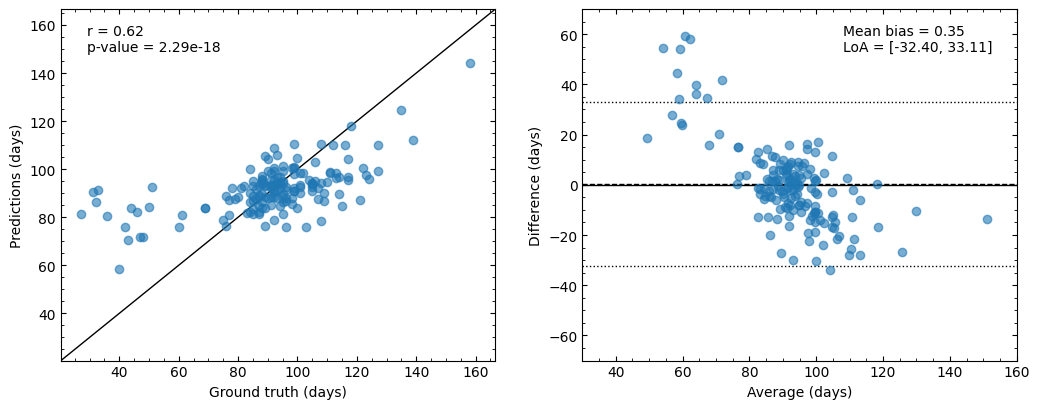

ms-aagcn-fts


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


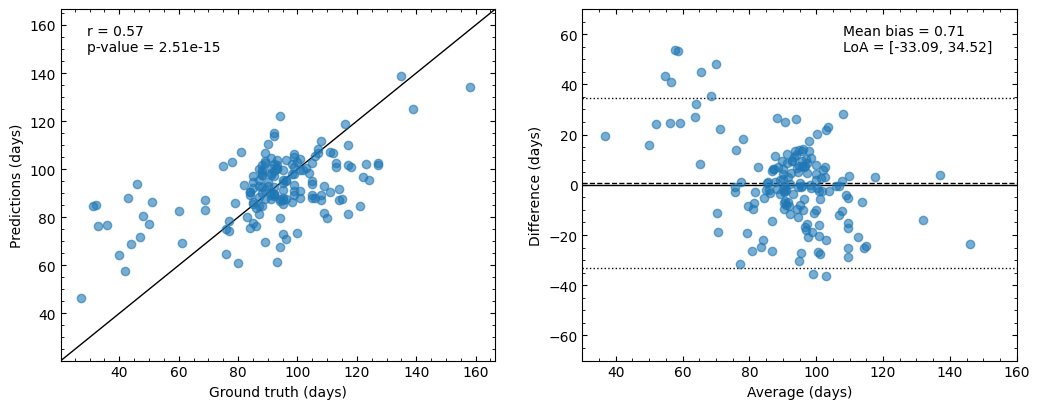

In [8]:
for model in models:
    print(model)
    
    model_df = df_val_all[df_val_all['model'] == model]
    grouped_df = model_df.groupby('test_id').agg({'y_true': ['mean', 'std'], 'y_pred': ['mean', 'std'], 'outcome': 'first'}).reset_index(drop=True)
    predictions = grouped_df[('y_pred', 'mean')]
    actual = grouped_df[('y_true', 'mean')]
    average = (predictions + actual) / 2
    difference = predictions - actual
    
    # Predicted vs Ground Truth Plot
    r, p_value = stats.pearsonr(grouped_df[('y_true', 'mean')], grouped_df[('y_pred', 'mean')])
    fig, ax = plt.subplots(1, 2, figsize=(10.5, 4.2))
    ax[0].axline((27, 27), (160, 160), color='k', lw=1, ls='-', zorder=0)
    ax[0].scatter(actual, predictions, c='tab:blue', alpha=0.6, zorder=1)
    ax[0].set_xlabel('Ground truth (days)')
    ax[0].set_ylabel('Predictions (days)')
    ax[0].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax[0].minorticks_on()
    ax[0].text(0.06, 0.88, f'r = {r:.2f}\np-value = {p_value:.2e}', transform=ax[0].transAxes)

    # Bland-Altman Plot
    mean_bias = difference.mean()
    limits_of_agreement = [mean_bias - 1.96 * difference.std(), mean_bias + 1.96 * difference.std()]
    ax[1].axhline(0, color='black', ls='-', lw=1, zorder=0)
    ax[1].axhline(mean_bias, color='k', ls='--', lw=1, zorder=0)
    ax[1].axhline(limits_of_agreement[0], color='k', ls=':', lw=1, zorder=0)
    ax[1].axhline(limits_of_agreement[1], color='k', ls=':', lw=1, zorder=0)
    ax[1].scatter(average, difference, alpha=0.6, zorder=1)
    ax[1].set_xlim([30, 160])
    ax[1].set_ylim([-70, 70])
    ax[1].set_xlabel('Average (days)')
    ax[1].set_ylabel('Difference (days)')
    ax[1].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax[1].minorticks_on()
    ax[1].text(0.6, 0.88, f'Mean bias = {mean_bias:.2f}\nLoA = [{limits_of_agreement[0]:.2f}, {limits_of_agreement[1]:.2f}]', transform=ax[1].transAxes)
    
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    
    for ext in ['png', 'pdf', 'eps']:
        plt.savefig(f'figures/{model}_scatter.{ext}', dpi=300)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


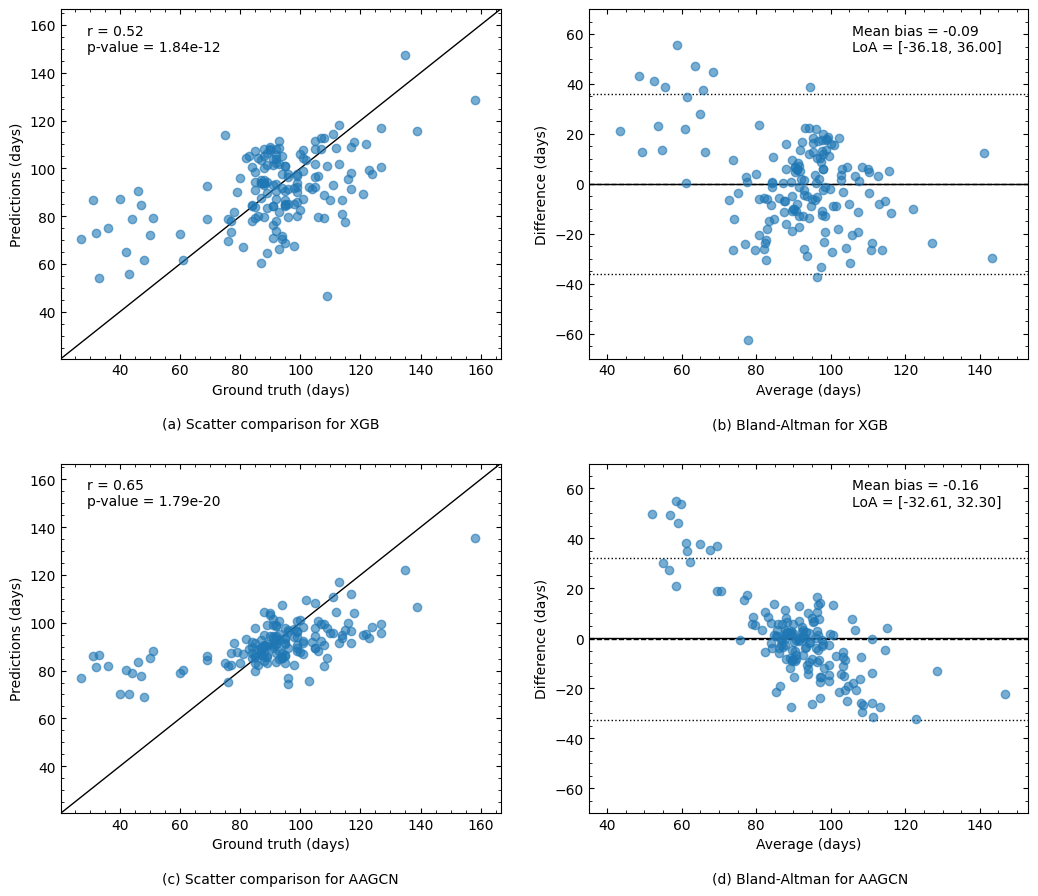

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10.5, 9))

letters = (l for l in ['a', 'b', 'c', 'd'])

for idx, model in enumerate(['xgb', 'aagcn']):
    model_df = df_val_all[df_val_all['model'] == model]
    grouped_df = model_df.groupby('test_id').agg({'y_true': ['mean', 'std'], 'y_pred': ['mean', 'std'], 'outcome': 'first'}).reset_index(drop=True)
    predictions = grouped_df[('y_pred', 'mean')]
    actual = grouped_df[('y_true', 'mean')]
    average = (predictions + actual) / 2
    difference = predictions - actual
    
    # Predicted vs Ground Truth Plot
    r, p_value = stats.pearsonr(grouped_df[('y_true', 'mean')], grouped_df[('y_pred', 'mean')])
    axs[idx, 0].axline((27, 27), (160, 160), color='k', lw=1, ls='-', zorder=0)
    axs[idx, 0].scatter(actual, predictions, c='tab:blue', alpha=0.6, zorder=1)
    axs[idx, 0].set_xlabel('Ground truth (days)')
    axs[idx, 0].set_ylabel('Predictions (days)')
    axs[idx, 0].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
    axs[idx, 0].minorticks_on()
    axs[idx, 0].text(0.06, 0.88, f'r = {r:.2f}\np-value = {p_value:.2e}', transform=axs[idx, 0].transAxes)
    axs[idx, 0].text(0.23, -0.2, f'({next(letters)}) Scatter comparison for {model.upper()}', transform=axs[idx, 0].transAxes)

    # Bland-Altman Plot
    mean_bias = difference.mean()
    limits_of_agreement = [mean_bias - 1.96 * difference.std(), mean_bias + 1.96 * difference.std()]
    axs[idx, 1].axhline(0, color='black', ls='-', lw=1, zorder=0)
    axs[idx, 1].axhline(mean_bias, color='k', ls='--', lw=1, zorder=0)
    axs[idx, 1].axhline(limits_of_agreement[0], color='k', ls=':', lw=1, zorder=0)
    axs[idx, 1].axhline(limits_of_agreement[1], color='k', ls=':', lw=1, zorder=0)
    axs[idx, 1].scatter(average, difference, alpha=0.6, zorder=1)
    axs[idx, 1].set_xlim([35, 153])
    axs[idx, 1].set_ylim([-70, 70])
    axs[idx, 1].set_xlabel('Average (days)')
    axs[idx, 1].set_ylabel('Difference (days)')
    axs[idx, 1].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
    axs[idx, 1].minorticks_on()
    axs[idx, 1].text(0.6, 0.88, f'Mean bias = {mean_bias:.2f}\nLoA = [{limits_of_agreement[0]:.2f}, {limits_of_agreement[1]:.2f}]', transform=axs[idx, 1].transAxes)
    axs[idx, 1].text(0.28, -0.2, f'({next(letters)}) Bland-Altman for {model.upper()}', transform=axs[idx, 1].transAxes)
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.3)

for ext in ['png', 'pdf', 'eps']:
    plt.savefig(f'figures/comparison_scatter.{ext}', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


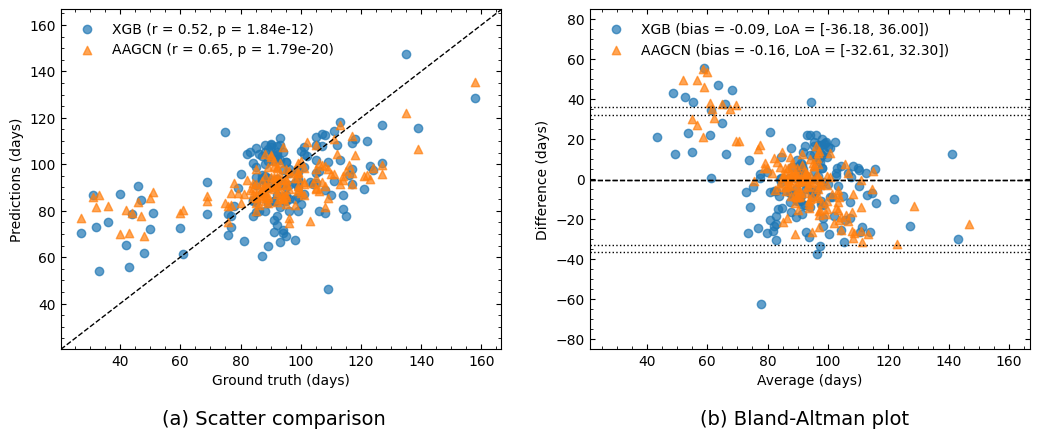

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 4.5))
markers = {'xgb': 'o', 'aagcn': '^'}

for idx, model in enumerate(['xgb', 'aagcn']):
    model_df = df_val_all[df_val_all['model'] == model]
    grouped_df = model_df.groupby('test_id').agg({'y_true': ['mean', 'std'], 'y_pred': ['mean', 'std'], 'outcome': 'first'}).reset_index(drop=True)
    predictions = grouped_df[('y_pred', 'mean')]
    actual = grouped_df[('y_true', 'mean')]
    average = (predictions + actual) / 2
    difference = predictions - actual
    
    # Predicted vs Ground Truth Plot
    r, p_value = stats.pearsonr(grouped_df[('y_true', 'mean')], grouped_df[('y_pred', 'mean')])
    ax[0].scatter(actual, predictions, alpha=0.7, marker=markers[model], label=f'{model.upper()} (r = {r:.2f}, p = {p_value:.2e})')
    ax[0].set_xlabel('Ground truth (days)')
    ax[0].set_ylabel('Predictions (days)')
    
    # Bland-Altman Plot
    mean_bias = difference.mean()
    limits_of_agreement = [mean_bias - 1.96 * difference.std(), mean_bias + 1.96 * difference.std()]
    ax[1].scatter(average, difference, alpha=0.7, marker=markers[model], label=f'{model.upper()} (bias = {mean_bias:.2f}, LoA = [{limits_of_agreement[0]:.2f}, {limits_of_agreement[1]:.2f}])')
    ax[1].set_xlabel('Average (days)')
    ax[1].set_ylabel('Difference (days)')
    ax[1].axhline(mean_bias, color='black', ls='--', lw=1)
    ax[1].axhline(limits_of_agreement[0], color='black', ls=':', lw=1)
    ax[1].axhline(limits_of_agreement[1], color='black', ls=':', lw=1)
    ax[1].set_xlim([21, 167])
    ax[1].set_ylim([-85, 85])

# Add identity line to scatter plot
ax[0].axline((27, 27), (160, 160), color='k', lw=1, ls='--')
ax[0].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax[0].minorticks_on()
ax[0].legend(loc='upper left', frameon=False)
ax[0].text(0.23, -0.22, '(a) Scatter comparison', transform=ax[0].transAxes, fontsize=14)

# Update legend positioning for Bland-Altman plot
ax[1].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax[1].minorticks_on()
ax[1].legend(loc='upper left', frameon=False)
ax[1].text(0.25, -0.22, '(b) Bland-Altman plot', transform=ax[1].transAxes, fontsize=14)

plt.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.3)

for ext in ['png', 'pdf', 'eps']:
    plt.savefig(f'figures/miccai_scatter.{ext}', dpi=300)
plt.show()

### Binned Predictions

lr


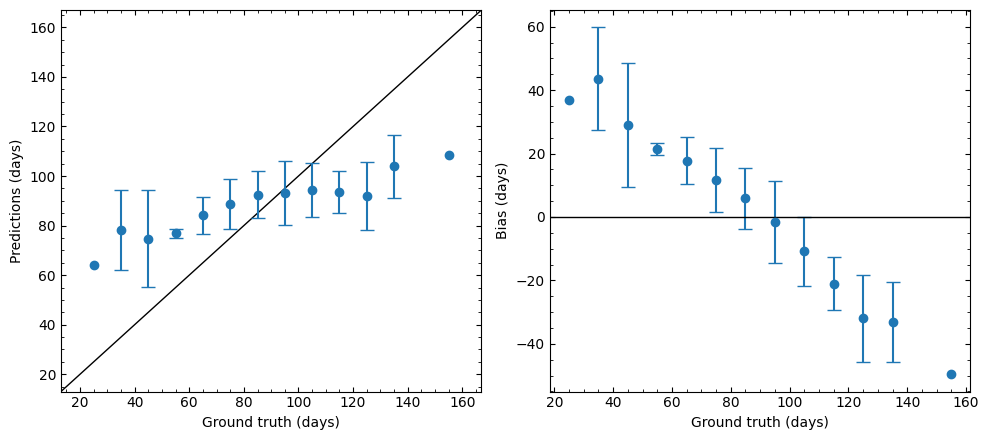

rf


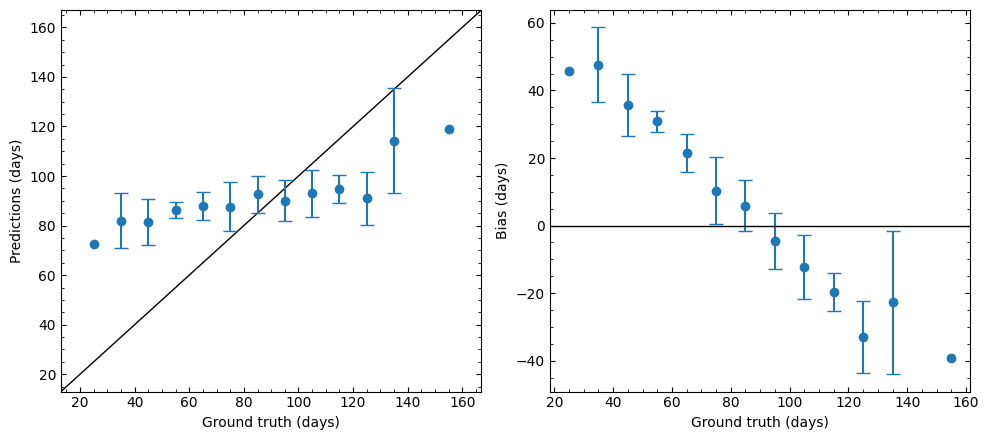

gb


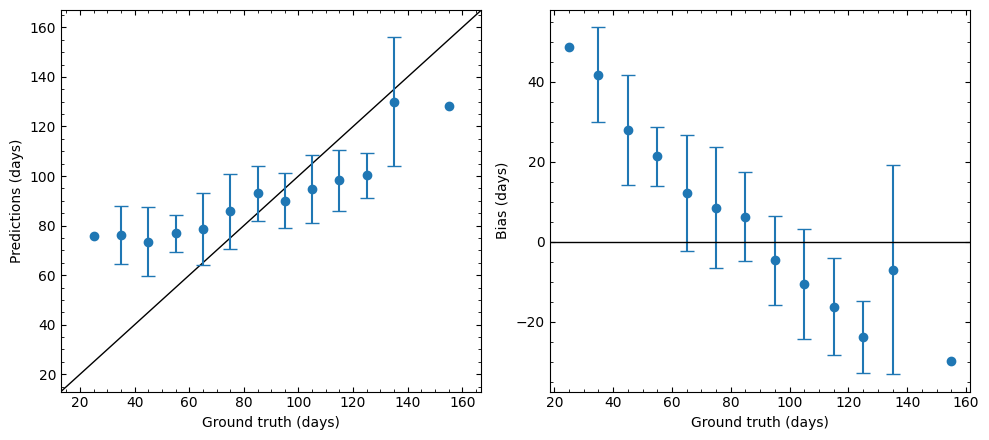

xgb


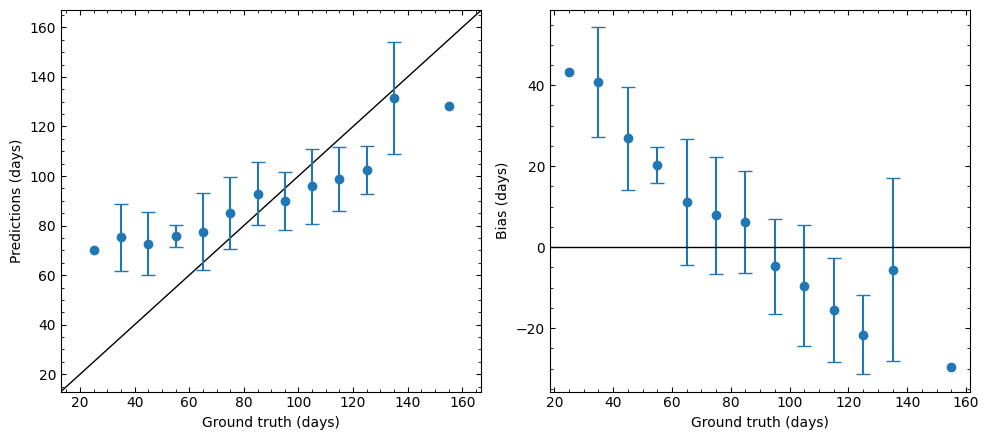

stgcn-physical


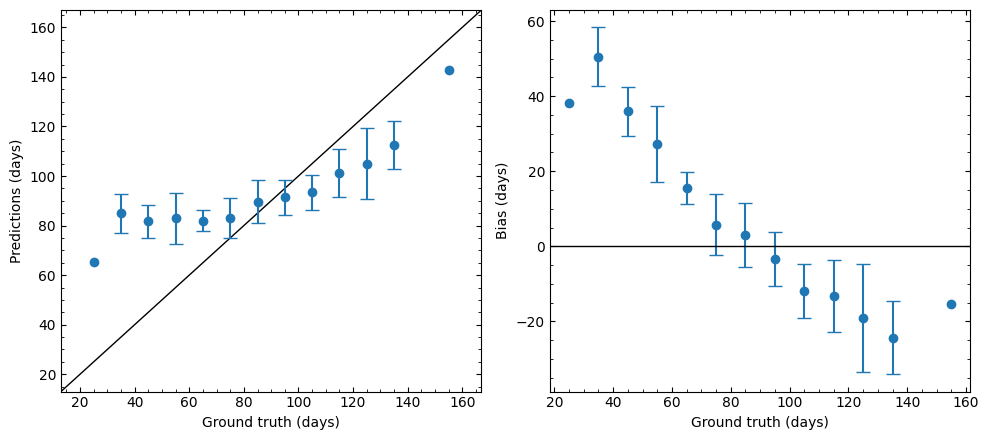

stgcn-xy


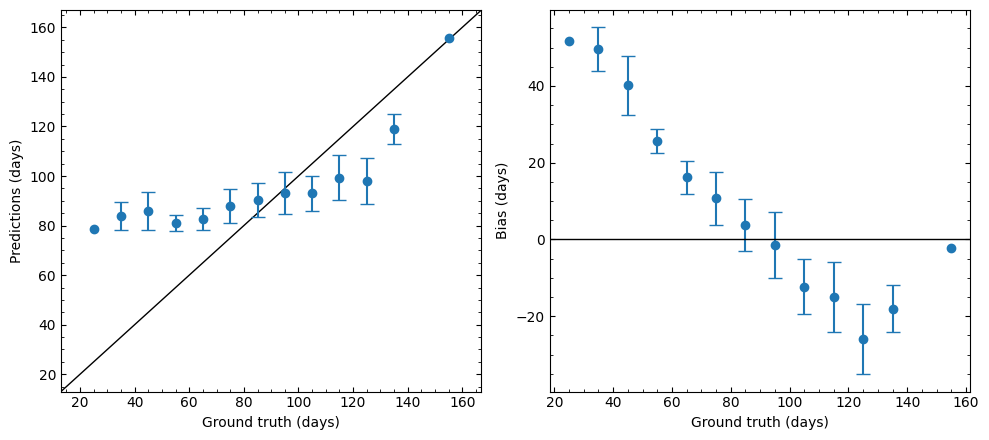

stgcn


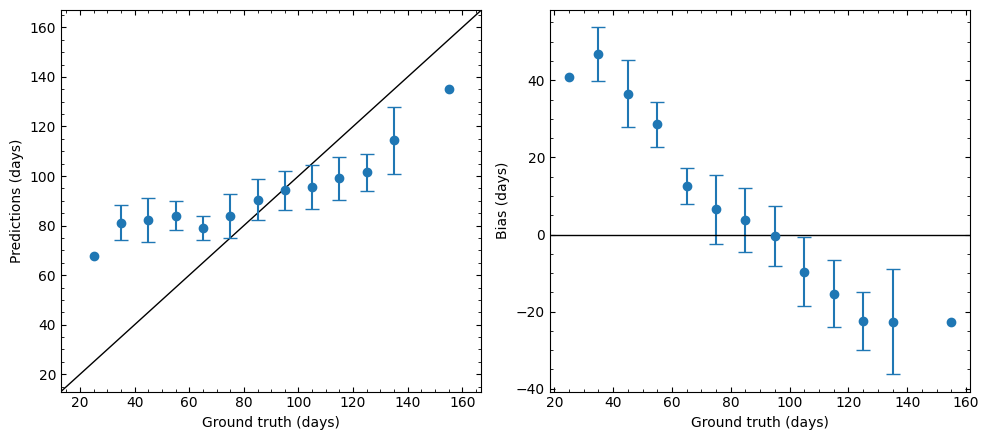

aagcn


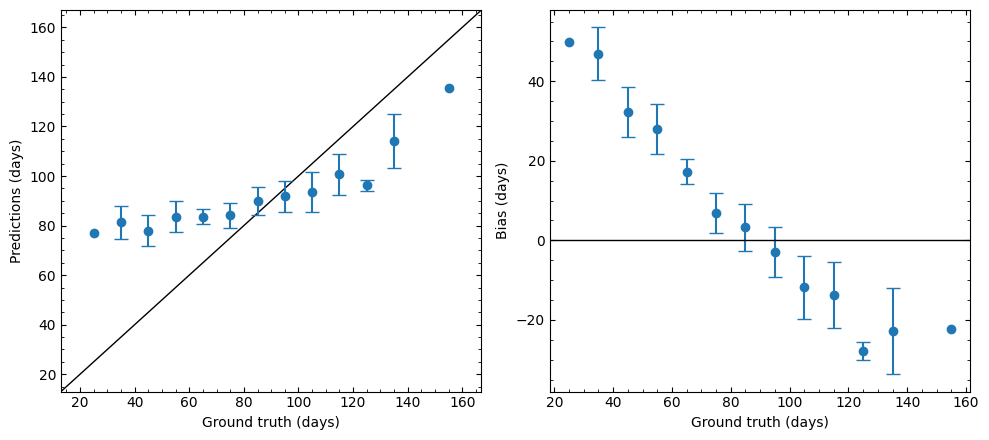

ms-aagcn


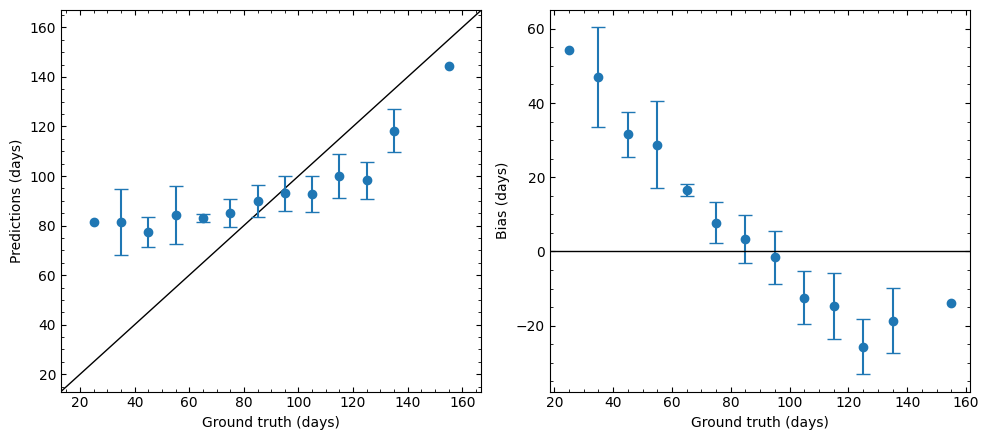

ms-aagcn-fts


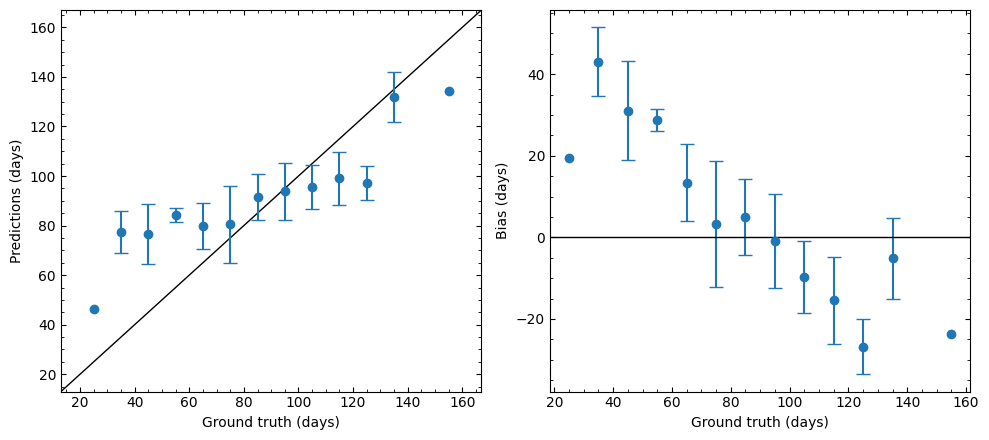

In [11]:
for model in models:
    print(model)

    # Filter data for the current model
    model_df = df_val_all[df_val_all['model'] == model]
    grouped_df = model_df.groupby('test_id').agg({'y_true': ['mean', 'std'], 'y_pred': ['mean', 'std'], 'outcome': 'first'}).reset_index(drop=True)

    # Simplifying the MultiIndex
    grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]

    # Create bins
    bins = np.arange(20, 170, 10)
    grouped_df['bins'] = pd.cut(grouped_df['y_true_mean'], bins)

    # Group by the bins
    grouped = grouped_df.groupby('bins')

    # Calculate mean and std of y_pred for each bin
    bin_means = grouped['y_pred_mean'].mean()
    bin_stds = grouped['y_pred_mean'].std()

    # Create the plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

    # Plotting average y_pred with std error and one-to-one line
    ax[0].axline((20, 20), (160, 160), color='k', lw=1, ls='-')
    ax[0].errorbar(x=[interval.mid for interval in bin_means.index.categories], y=bin_means, yerr=bin_stds, fmt='o', capsize=5)
    ax[0].set_xlabel('Ground truth (days)')
    ax[0].set_ylabel('Predictions (days)')
    ax[0].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax[0].minorticks_on()

    # Calculate and Plot Bias
    bin_bias_means = grouped.apply(lambda x: (x['y_pred_mean'] - x['y_true_mean']).mean())
    bin_bias_stds = grouped['y_pred_mean'].std()
    ax[1].errorbar(x=[interval.mid for interval in bin_means.index.categories], y=bin_bias_means, yerr=bin_bias_stds, fmt='o', capsize=5)
    ax[1].axhline(0, color='k', ls='-', lw=1)
    ax[1].set_xlabel('Ground truth (days)')
    ax[1].set_ylabel('Bias (days)')
    ax[1].tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax[1].minorticks_on()

    plt.tight_layout()
    plt.show()